In [24]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from functions import *

In [53]:
#GRAPH STRUCTURE OPTIMIZATION TEST
x = np.linspace(0,math.pi,100)
y = np.sin(x)#2*x+1
data = {"x":x,"y":y}

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encounte

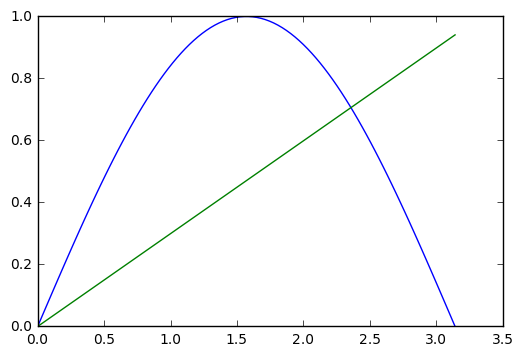

evolving generation 0 of 1


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


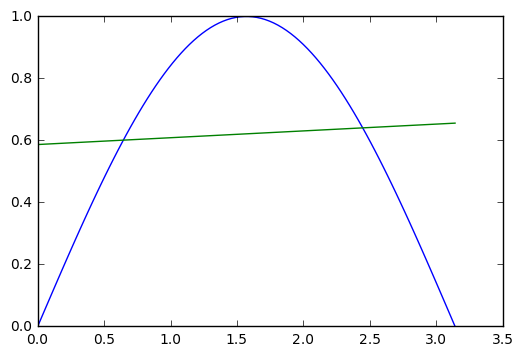

min error at generation n.0: 10.1703144055
{'specimen': <functions.Tree object at 0x7fcd60434898>, 'error': 10.170314405498315}


In [59]:
print(evolution(data, 1))

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-

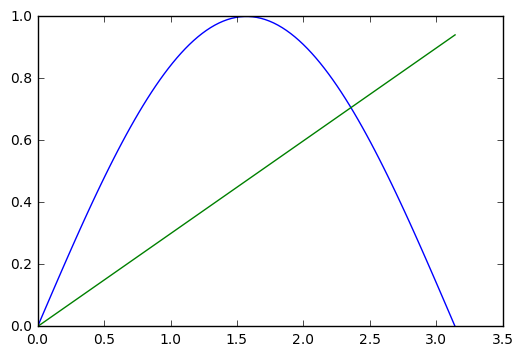

[{'input': [], 'arg_index': 0, 'lib_id': 0}, {'input': [], 'arg_index': 1, 'lib_id': 0}, {'input': [0, 1], 'lib_id': 3}]
evolving generation 0 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:302: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON


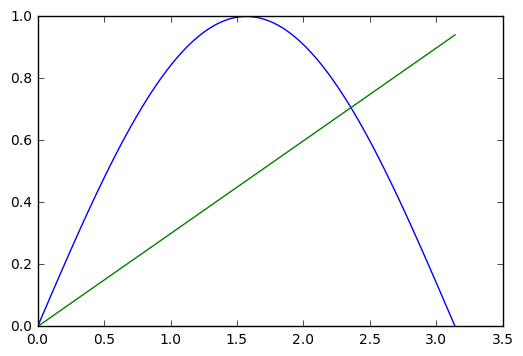

min error at generation n.0: 20.4080514187
evolving generation 1 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


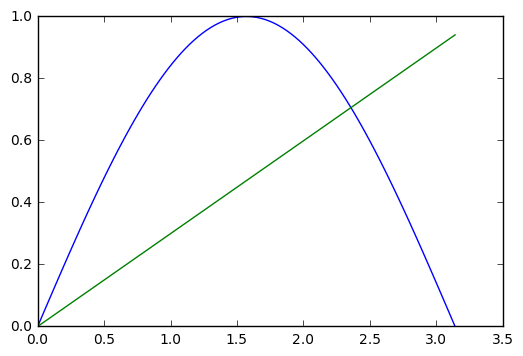

min error at generation n.1: 20.3386210675
evolving generation 2 of 5


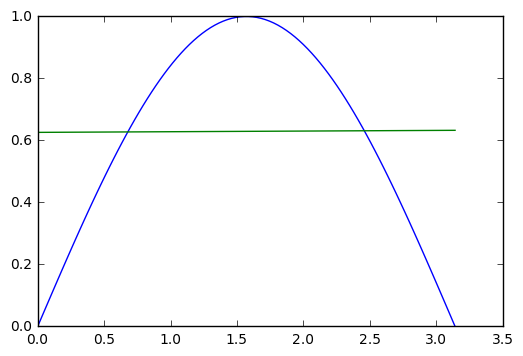

min error at generation n.2: 11.4117379122
evolving generation 3 of 5


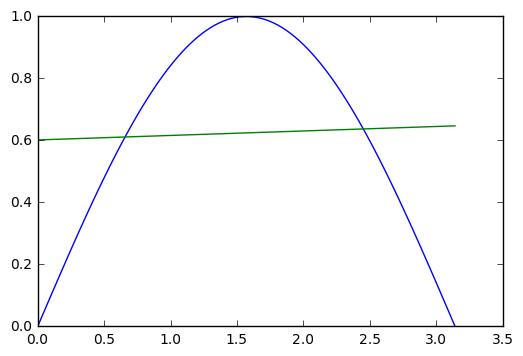

min error at generation n.3: 11.3620381089
evolving generation 4 of 5


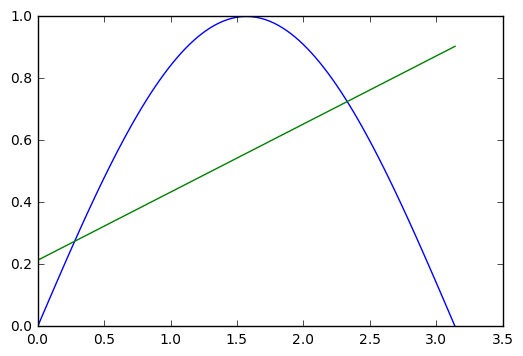

min error at generation n.4: 17.8369963654


In [29]:
%lprun -f evolution evolution(data, 5)

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:299: RuntimeWarning: invalid value encountered in subtract
  value_there = np.array([ func(values+dx[i]) for i in range(len(values)) ])
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:299: RuntimeWarning: invalid value encountered in subtract
  value_there = np.array([ func(values+dx[i]) for i in range(len(values)) ])
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: Runtime

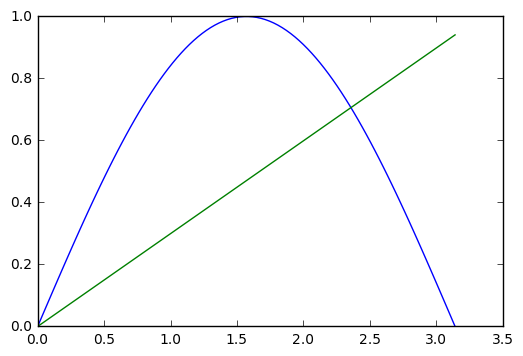

evolving generation 0 of 5


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:299: RuntimeWarning: invalid value encountered in subtract
  value_there = np.array([ func(values+dx[i]) for i in range(len(values)) ])
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


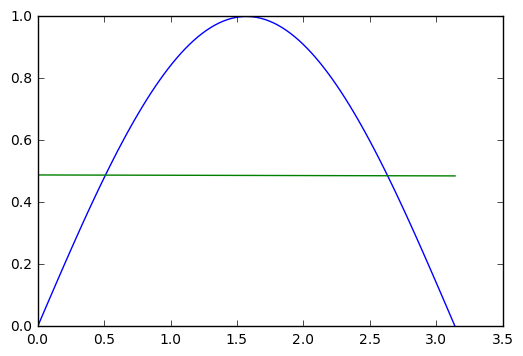

min error at generation n.0: 12.3210130882
evolving generation 1 of 5


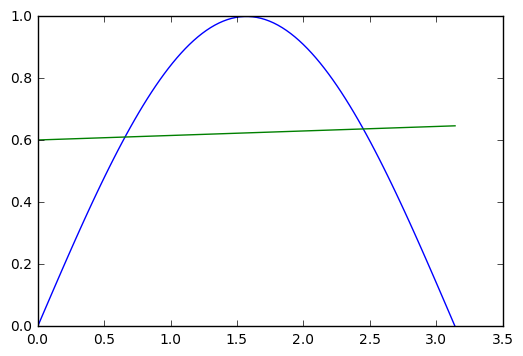

min error at generation n.1: 10.2130034178
evolving generation 2 of 5


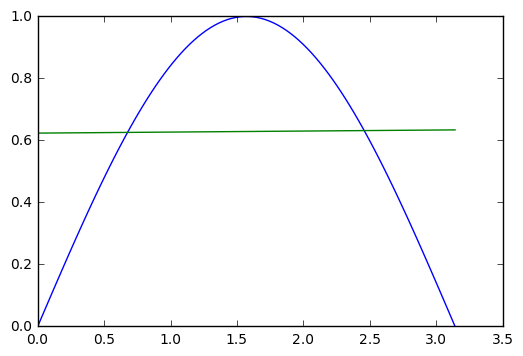

min error at generation n.2: 10.1774185267
evolving generation 3 of 5


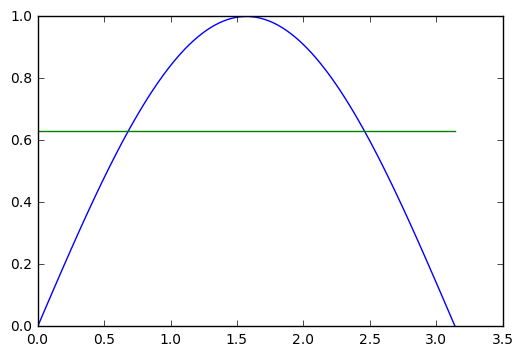

min error at generation n.3: 10.0047542766
evolving generation 4 of 5


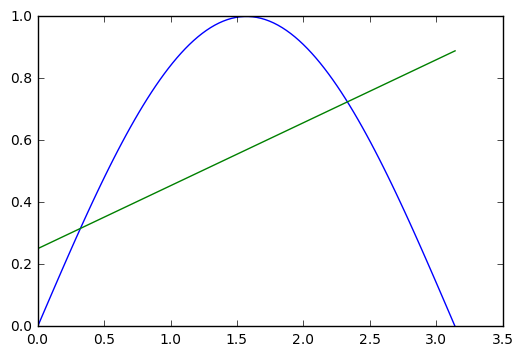

min error at generation n.4: 16.1087590703
{'specimen': <functions.Tree object at 0x7fcd69e62080>, 'error': 10.004754276569084}
fittest specimen:


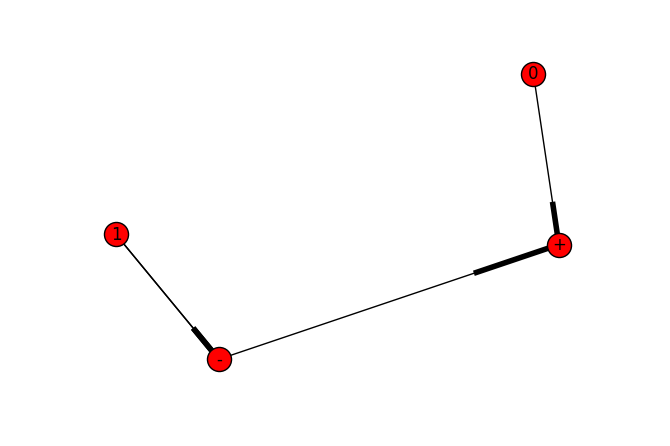

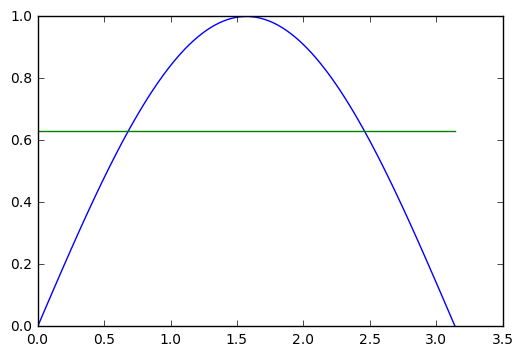

CPU times: user 21.3 s, sys: 272 ms, total: 21.6 s
Wall time: 32.7 s


In [49]:
%%time
e = evolution(data, 5)
print(e)
# Export resulting graph to json file
# You can view it by starting a webserver(python2 -m SimpleHTTPServer) and then going to http://localhost:8000/graph_viewer.html
e["specimen"].export_json()
print("fittest specimen:")
e["specimen"].draw()
e["specimen"].plot_optimized(data)

In [51]:
e["specimen"].export_json()

In [22]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
%lprun -f optimize optimize(lib[7]["graph"],data,0)

{'iterations': 51, 'parameters': array([ 0.81006931,  2.04725724]), 'error': 7.5945441550180899, 'X': 0}


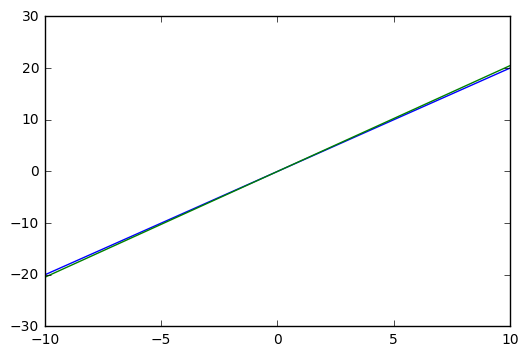

In [416]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
result = optimize(lib[7]["graph"],data,0)
print(result)
values = result["parameters"]
x_pos = result["X"]
#input_size*number_of_data_points matrix that contains a list of input vectors like [parameter1, parameter2, x_value, ...]
value_matrix = [[(xe if v == x_pos else value) for v, value in enumerate(values)] for xe in x]
y = np.array([ evaluate(lib[7]["graph"],value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)
pylab.show()

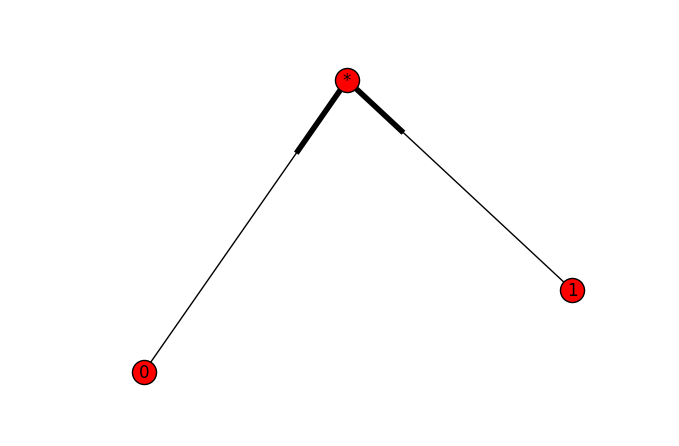

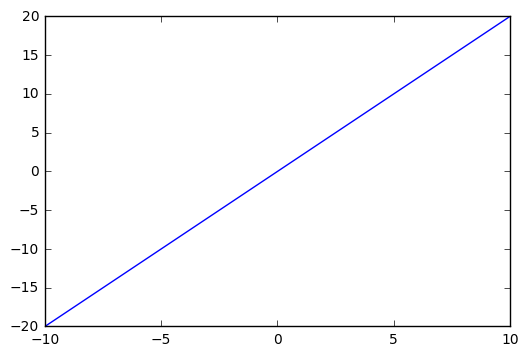

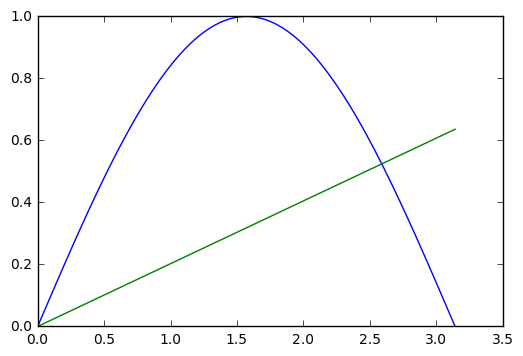

In [352]:
draw(lib[7]["graph"])
plot_specimen(lib[7]["graph"],[2,2])
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
plot_optimized(lib[7]["graph"],data)

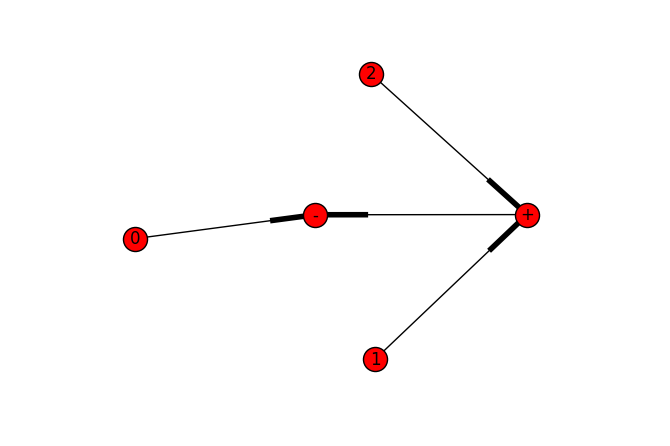

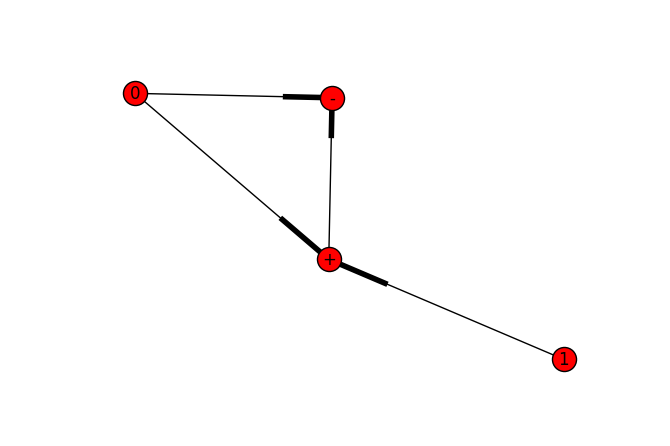

In [353]:
g3 = insert_at(lib[5]["graph"],lib[6]["graph"])
draw(g3)
g4 = merge_input_entries(g3)
draw(g4)

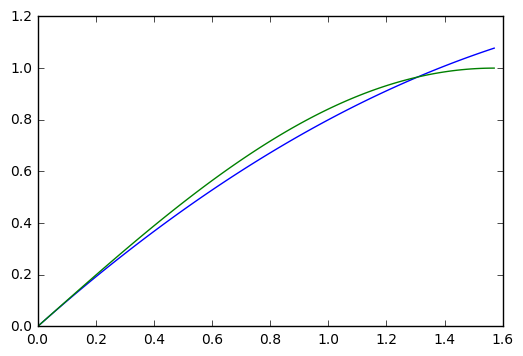

In [357]:
pylab.close()
x = np.linspace(0,math.pi/2,100)
y = x-0.2*x**2
pylab.plot(x,y)
y = np.sin(x)
pylab.plot(x,y)
pylab.show()